In [1]:
import numpy as np
import math 
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
def keys(f):
    return [key for key in f.keys()]
import scipy
from scipy import signal
from scipy.fftpack import fft, fftshift ,ifft,rfft,fftfreq,rfftfreq

from scipy.interpolate import CubicSpline as spline
#h5py.run_tests()
c=2.9979e10
G=6.67408e-8
Msun=1.989e33
Length = G*Msun/c**2
Time = Length/c
Frequency=1/Time

In [2]:
def fre_do(x,y,mass):
    fd=fft(y)
    N=len(y)
    T=x[1]-x[0]
    xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))/mass
    fq=fftfreq(len(y))
    mask=fq>=0
    fd=2.0*(fd/N)
    fd=fd[mask]
    fd=abs(fd)
    
    return xf,fd
    

In [3]:
def analyze(rh,mass):
    
    
    
    rhM=rh[:,1]
    time=rh[:,0]
    
    peaks,prop=scipy.signal.find_peaks(abs(rhM))
    ampls=rhM[peaks]
    merg=np.amax(abs(ampls))
    merg=np.where(abs(ampls)==merg)
    merg=int(merg[0])
    t0=peaks[merg]
    
    ampl=rhM[t0:]
    tim=time[t0:]
    
    tuk=signal.tukey(len(ampl))
    dat=ampl*tuk
    
    fq,fd=fre_do(tim,dat,mass)
    
    mx=np.where(fd==np.amax(fd))[0][0]
    freq=fq[mx]
    amp=fd[mx]
    return freq,amp
    

Example of the way we will performe the analysis

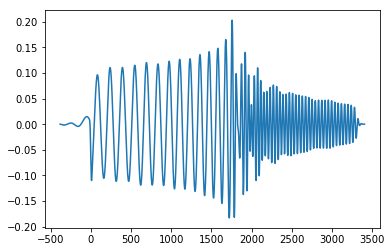

In [4]:
name = 'data/BAM:0002.h5'                   #change that

                                    #change that


file=h5py.File(name,'r')
dat = list(file["/rh_22"])
rh = np.array(file["/rh_22/%s" %dat[-1]])
plt.plot(rh[:,0],rh[:,1])
plt.show()

peaks,prop=scipy.signal.find_peaks(abs(rh[:,1]))
ampls=rh[peaks,1]
merg=np.amax(abs(ampls))
merg=np.where(abs(ampls)==merg)
merg=int(merg[0])
t0=peaks[merg]

In [5]:
rh[t0,1]

0.2030496

In [6]:
ampl=rh[t0:,1]
tim=rh[t0:,0]

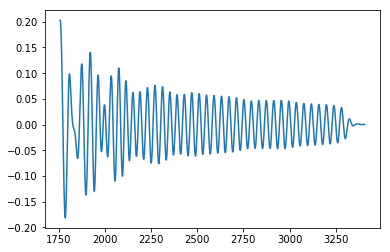

In [7]:
plt.plot(tim,ampl)

In [8]:
tuk=signal.tukey(len(ampl))
dat=ampl*tuk

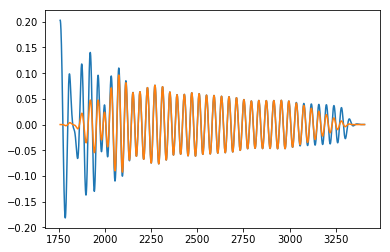

In [9]:
plt.plot(tim,ampl)
plt.plot(tim,dat)

In [10]:
y=dat
x=tim
fd=fft(y)
N=len(y)
T=x[1]-x[0]
xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))/2.7
fq=fftfreq(len(y))
mask=fq>=0
fd=2.0*(fd/N)
fd=fd[mask]
fd=abs(fd)

(0, 2500)

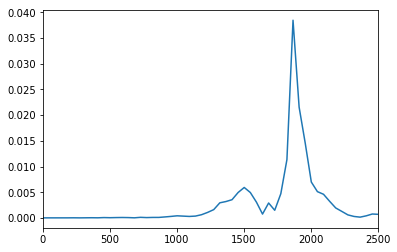

In [11]:
plt.plot(xf*Frequency,fd)
plt.xlim(0,2500)
#plt.xlim(1850,1880)

Read metadata for BAM

In [12]:

SLy=1
H4=2
MS1=3
MPA1=4
ALF2=5
MS1b=6
ms1b=6
ENG=7


BHBlp=9
DD2=10
LS220=11
SFHo=12


In [13]:
mas2=np.zeros(31)
eos2=np.zeros(31)

i=0
for m in range(0,2):
    for k in range(0,10):
        for j in range(0,10):
            name = 'metadata/BAM:0%s%s%s.txt' %(m,k,j)
            try:
                f=open(name)
                lines=f.readlines() 
                
                exec(lines[8])
                mas2[i]=id_mass
                
                if i==0:
                    eos2[i]=8 #by hand because 2H can not be given a value
                if i>0:
                    exec(lines[15])
                    eos2[i]=id_eos
                
                
                i=i+1
            except OSError:
                pass

Read metadata for THC

In [14]:
mas1=np.zeros(23)
eos1=np.zeros(23)

i=0
for m in range(0,2):
    for k in range(0,10):
        for j in range(0,10):
            name = 'metadata/THC:0%s%s%s.txt' %(m,k,j)
            try:
                f=open(name)
                lines=f.readlines() 
                
                exec(lines[8])
                mas1[i]=id_mass
                exec(lines[15])
                eos1[i]=id_eos
                
                
                i=i+1
            except OSError:
                pass

Analyze data for BAM

In [15]:
freq2=np.zeros(31)
amp2=np.zeros(31)
i=0
for m in range(0,2):
    for k in range(0,10):
        for j in range(0,10):
            name = 'data/BAM:0%s%s%s.h5' %(m,k,j)
            try:
                file=h5py.File(name,'r')
                dat = list(file["/rh_22"])
                rh = np.array(file["/rh_22/%s" %dat[-1]])
                
                freq2[i],amp2[i]=analyze(rh,mas2[i])
                
                i=i+1
            except OSError:
                pass

Analyze data for THC

In [16]:
freq1=np.zeros(23)
amp1=np.zeros(23)
i=0
for m in range(0,2):
    for k in range(0,10):
        for j in range(0,10):
            name = 'data/THC:0%s%s%s.h5' %(m,k,j)
            try:
                file=h5py.File(name,'r')
                dat = list(file["/rh_22"])
                rh = np.array(file["/rh_22/Rh_l2_m2_r00400.txt" ])
                
                freq1[i],amp1[i]=analyze(rh,mas1[i])
                
                i=i+1
            except OSError:
                pass

In [17]:
freq=np.concatenate((freq1,freq2))
mas=np.concatenate((mas1,mas2))
eos=np.concatenate((eos1,eos2))

Get the $M_{TOV}$ from the eos

In [18]:
mtov=np.zeros(len(eos))
for i in range(len(eos)):
    if eos[i]==1:
        mtov[i]=2.06
    if eos[i]==2:
        mtov[i]=2.03
    if eos[i]==3:
        mtov[i]=2.77
    if eos[i]==4:
        mtov[i]=2.77
    if eos[i]==5:
        mtov[i]=1.99
    if eos[i]==6:
        mtov[i]=2.76
    if eos[i]==7:
        mtov[i]=2.25
    if eos[i]==8:
        mtov[i]=2.83
    if eos[i]==9:
        mtov[i]=2.10
    if eos[i]==10:
        mtov[i]=2.42
    if eos[i]==11:
        mtov[i]=2.04
    if eos[i]==12:
        mtov[i]=2.06
        
        

In [19]:
mtov

array([2.1 , 2.1 , 2.1 , 2.1 , 2.1 , 2.1 , 2.1 , 2.42, 2.42, 2.42, 2.42,
       2.42, 2.42, 2.42, 2.42, 2.04, 2.04, 2.04, 2.04, 2.76, 2.06, 2.06,
       2.06, 2.83, 1.99, 1.99, 1.99, 1.99, 2.25, 2.03, 2.03, 2.03, 2.03,
       2.03, 2.03, 2.77, 2.77, 2.77, 2.76, 2.76, 2.76, 2.76, 2.76, 2.76,
       2.76, 2.76, 2.06, 2.06, 2.06, 2.06, 2.06, 2.06, 2.06, 2.06])

Calculate $\zeta=k_{eff}+a\frac{M}{M_{TOV}}$

In [20]:
lamda=np.load('results/lamda.npy')
k=(3/16)*lamda
a=-131.7010
zeta=k+a*mas/mtov

In [21]:
zeta

array([  86.08182908,   33.00548678,  -10.32142752,   26.68377718,
         35.24072485,  -46.10819028,  -55.56851882,  171.68394355,
        106.81398177,   54.56692559,   12.06929739,   48.3696089 ,
         56.80216366,  -22.88817926,  -76.53715877,  114.87372782,
        -46.10427517,    2.83208787,   -0.33493519,  158.32450272,
        -63.70244761,  -65.31076388,  -99.47211553,  292.22476664,
        -45.19227387,  -45.86532499,   43.6993219 ,  -44.18726808,
        -71.30809228,   25.49667876,   24.99948142,   28.68587172,
          6.60765184,   20.13903064,   38.72474193,  -17.81392419,
        190.93699165,  186.05022367,  150.55869034,  122.17827027,
        307.97886762,  127.81299553,  -43.14494817,  139.67972946,
        -85.46538141,  155.37377553, -101.881405  ,  -26.5365658 ,
        -39.45337995,  -74.31977195, -100.57917248,  -29.02789471,
       -109.81203018, -102.07237562])

In [22]:
np.save('results/zeta.npy',zeta)
np.save('results/freq.npy',freq)
np.save('results/mas.npy',mas)

(0.02, 0.05)

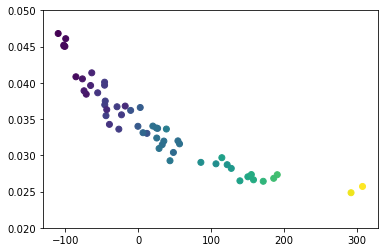

In [23]:
plt.scatter(zeta,mas*freq,c=lamda)
plt.ylim(0.02,0.05)

In [24]:
q=np.load('results/q.npy')

In [25]:
q2=q[23:]
q1=q[:23]

(0, 0.03)

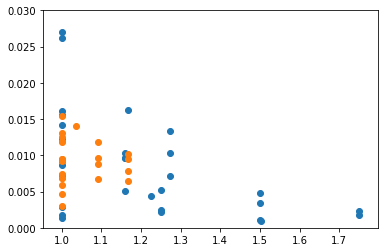

In [26]:
plt.scatter(q2,amp2/mas2)
plt.scatter(q1,amp1/mas1)
plt.ylim(0,0.030)